# SHAP Analysis for ML Model Interpretation

A notebook demonstrating XGBoost model training on reactivity ratios (RR) for a radical polymerization dataset, with SHAP interpretation of feature importance.

+ Github Repo: https://github.com/shap/shap
+ Introduction Ref: 
    + https://christophm.github.io/interpretable-ml-book/shap.html
    + https://christophm.github.io/interpretable-ml-book/shapley.html
+ Dataset reference: https://github.com/TheJacksonLab/ReactivityRatios


## Brief theory introduction

### Shapley value

The Shapley value, coined by Shapley (1953), is a method for assigning payouts to players based on their contribution to the total payout in game theory.

It can be applied to help assign feature importance in machine learning studies through a series of analogies: the "game" is the prediction task for a single instance of the dataset; the "gain" is the actual prediction for this instance minus the average prediction for all instances; the "players" are the features.

The main idea of the Shapley value is to account for feature importance by assessing the average marginal contribution of a feature value (see Introduction Ref for details). **The Shapley value of a feature is its contribution to the predicted value.** 

In the following equation, $\hat{f}(x)$ is the model prediction with a given feature vector $x$ containing $p$ features, $\phi_j$ is the Shapley value of feature $j$, and $\hat{f}(x) - \mathbb{E}[\hat{f}(x)]$ is the difference between the prediction and the expectation (average) across the dataset. This shows that the overall contribution to the final prediction can be well attributed to different features.

$$\sum_{j=1}^{p} \phi_j = \hat{f}(x) - \mathbb{E}[\hat{f}(x)]$$


<!-- For example, if we are predicting the price of a estate, its location (e.g. whether or not near a park, left in figure), area (middle in the figure), and pets policy (the feature we are interested in, right in figure) are thought to determining the price.  -->

### SHAP

SHAP (SHapley Additive exPlanations) by Lundberg and Lee (2017) is a method to explain individual predictions, based on the game-theoretically optimal Shapley values. It made Shapley values popular in machine learning. SHAP enables using Shapley values to interpret various modern machine learning models, including kernel models, tree models and neural networks, with decent speed.



## Dependency installation & import

In [14]:
## SHAP and xgboost need to be installed seperately besides scikit-learn
# ! pip install shap
# ! pip install xgboost


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

random_state = 42

## Dataset loading and standardization

In [16]:
# read (X_train, y_train) and (X_test, y_test) to csv file
train_file = 'train_data.csv'
test_file = 'test_data.csv'

training_worksheet = pd.read_csv(train_file)
test_worksheet = pd.read_csv(test_file)

print("Training data shape:", training_worksheet.shape)
print("Test data shape:", test_worksheet.shape)

Training data shape: (6336, 14)
Test data shape: (1314, 14)


### Summary of dataset

Test Ratio: 0.2

Features: Frontier molecular orbital (FMO) energy of the two monomers. (12 features)

Target: log_r, which is the log value of the reactivity ratio.

In [17]:
training_worksheet.head(3)

,monomer,log_r,mol1_HOMO_1,mol1_HOMO,mol1_LUMO,mol1_LUMO_Add1,mol2_HOMO_1,mol2_HOMO,mol2_LUMO,mol2_LUMO_Add1,rad1_HOMO_1,rad1_HOMO,rad1_LUMO,rad1_LUMO_Add1
0,"Oxazoline, 2-, 2-isopropenyl-.Styrene",0.64,-0.228400,-0.200261,-0.062436,0.026590,-0.230012,-0.203579,-0.064886,-0.034535,-0.204315,-0.160277,-0.110536,0.023523
1,"Oxazoline, 2-, 2-isopropenyl-.Styrene",0.68,-0.228400,-0.200261,-0.062436,0.026590,-0.230012,-0.203579,-0.064886,-0.034535,-0.204315,-0.160277,-0.110536,0.023523
2,Acrylonitrile.Vinyltrimethylsilane,4.08,-0.307886,-0.266671,-0.092915,-0.013216,-0.255616,-0.233763,-0.037205,0.022599,-0.292009,-0.205459,-0.146590,-0.015383


In [18]:
X_train, y_train = training_worksheet.iloc[:, 2:], training_worksheet.iloc[:, 1]
X_test, y_test = test_worksheet.iloc[:, 2:], test_worksheet.iloc[:, 1]

print("Training data shapes:", X_train.shape, y_train.shape)
print("Test data shapes:", X_test.shape, y_test.shape)

Training data shapes: (6336, 12) (6336,)
Test data shapes: (1314, 12) (1314,)


In [19]:
# Preprocessing x and y
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = X_train_scaled
X_test = X_test_scaled

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)


## XGBoost Model Training and Evaluation

In [20]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 
best_params = {'colsample_bytree': 0.9,
  'gamma': 0.1,
  'learning_rate': 0.1,
  'max_depth': 10,
  'min_child_weight': 1,
  'n_estimators': 200,
  'reg_alpha': 0,
  'reg_lambda': 2,
  'subsample': 0.9}

best_xgb_model = XGBRegressor(
    random_state=random_state,
    objective='reg:squarederror',
    eval_metric='rmse',
    n_jobs=-1,
    **best_params
)

best_xgb_model.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [21]:
y_train_log_pred = best_xgb_model.predict(X_train)
y_test_log_pred  = best_xgb_model.predict(X_test)

# Compute evaluation metrics
train_log_mse = mean_squared_error(y_train_log, y_train_log_pred)
test_log_mse  = mean_squared_error(y_test_log, y_test_log_pred)

train_log_rmse = np.sqrt(train_log_mse)
test_log_rmse  = np.sqrt(test_log_mse)

train_log_mae = mean_absolute_error(y_train_log, y_train_log_pred)
test_log_mae  = mean_absolute_error(y_test_log, y_test_log_pred)

train_log_r2 = r2_score(y_train_log, y_train_log_pred)
test_log_r2  = r2_score(y_test_log, y_test_log_pred)

# Print evaluation results
print(f"\nTrain MSE: {train_log_mse:.4f}")
print(f"Test MSE:  {test_log_mse:.4f}")
print(f"\nTrain RMSE: {train_log_rmse:.4f}")
print(f"Test RMSE:  {test_log_rmse:.4f}")
print(f"\nTrain MAE: {train_log_mae:.4f}")
print(f"Test MAE:  {test_log_mae:.4f}")
print(f"\nTrain R²: {train_log_r2:.4f}")
print(f"Test R²:  {test_log_r2:.4f}")



Train MSE: 0.2103
Test MSE:  1.4304

Train RMSE: 0.4586
Test RMSE:  1.1960

Train MAE: 0.2577
Test MAE:  0.8158

Train R²: 0.9174
Test R²:  0.5059


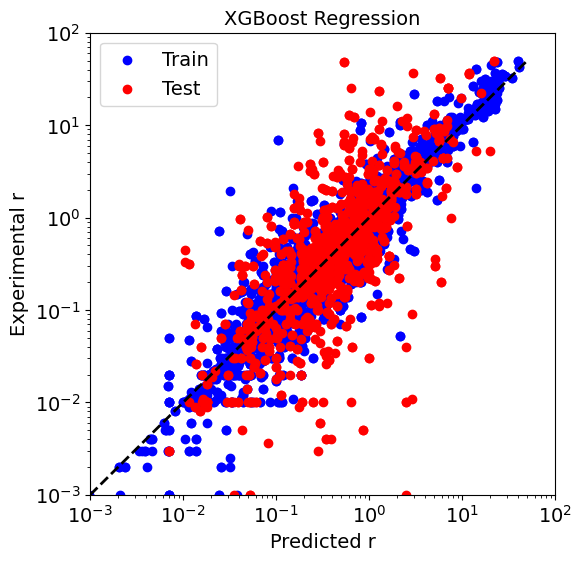

In [22]:
# plot results
plt.figure(figsize=(6, 6))

# the dataset contains reactivity ratio (RR) in log scale
plt.scatter(np.exp(y_train_log_pred),y_train,  color='blue', label='Train')
plt.scatter(np.exp(y_test_log_pred),y_test,  color='red', label='Test')

plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.ylabel('Experimental r', fontsize=14)
plt.xlabel('Predicted r', fontsize=14)
plt.xlim(1E-3, 100)
plt.ylim(1E-3, 100)
plt.xscale('log')
plt.yscale('log')

# adjust axis font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('XGBoost Regression', fontsize=14)
plt.legend(fontsize=14)
plt.show()


## SHAP Analysis: Shapley value calculation

In [23]:
import shap

# Initialize the SHAP TreeExplainer with your trained model
explainer = shap.TreeExplainer(best_xgb_model)

# Compute SHAP values for your training data
shap_values = explainer.shap_values(X_test)

feature_names = test_worksheet.columns[2:]

## SHAP Analysis: summary plot
X-axis is the SHAP value, *i.e.* contribution of the feature value to the prediction on a data serie.

y-axis is feature names.

Color denotes the value of the feature (high or lower energy of frontier orbital in our case), red denotes high orbital energy while blue denotes low orbital energy.

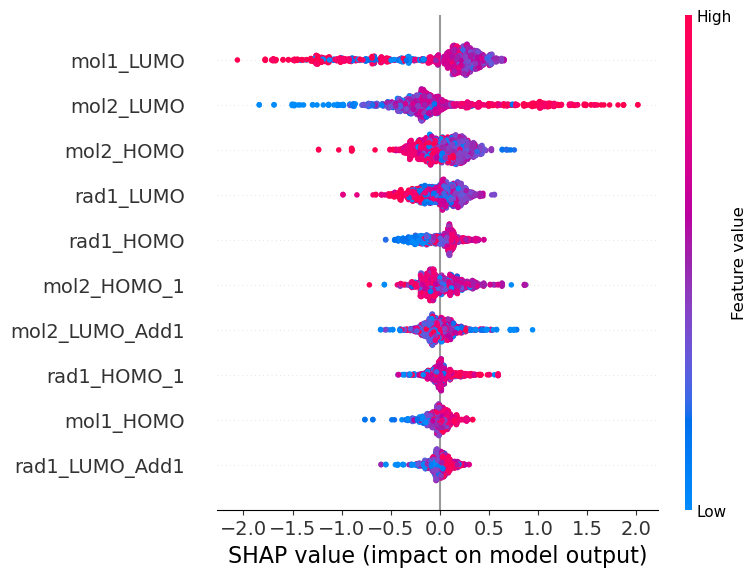

In [24]:
# Set matplotlib parameters for larger fonts
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14}) 

# Create the SHAP summary plot
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=feature_names, 
    max_display=10,
    plot_size=(8, 6),
    show=False  # Don't show the plot yet so we can modify it
)

# Get the current figure and adjust font sizes
plt.xlabel('SHAP value (impact on model output)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adjust legend if present
legend = plt.gca().get_legend()
if legend is not None:
    for text in legend.get_texts():
        text.set_fontsize(16)

plt.tight_layout()
plt.show()

## SHAP Analysis: Waterfall Plot

The plot shows how does each feature contribute to $\hat{f}(x) - \mathbb{E}[\hat{f}(x)]$ on instance X_test[0].

Explaining prediction for test instance 0:
Actual y_test[0]: 0.0400
Predicted y_test[0]: 0.0476
Base (expected) value: 0.4434


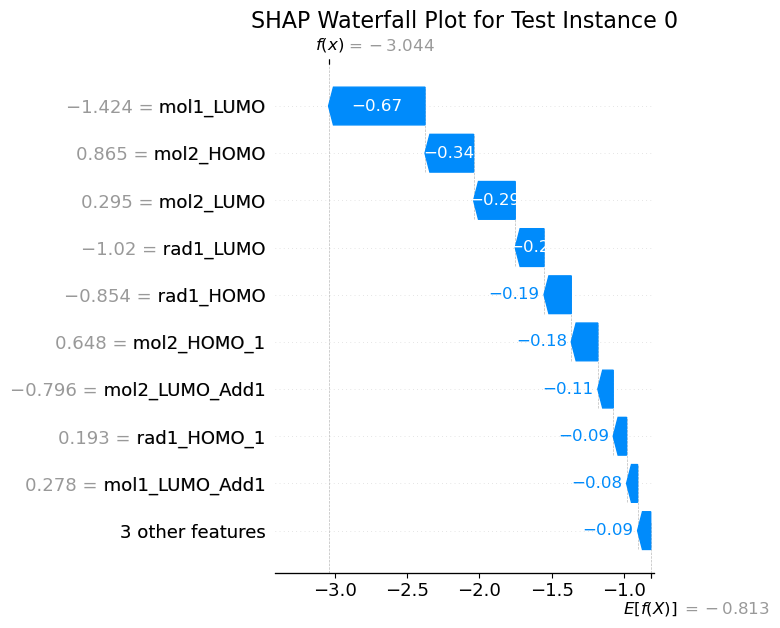


Top 10 most important features for test instance 0:
Feature Name | SHAP Value | Feature Value
--------------------------------------------------
mol1_LUMO                 |  -0.6677 |  -1.4236
mol2_HOMO                 |  -0.3365 |   0.8648
mol2_LUMO                 |  -0.2883 |   0.2947
rad1_LUMO                 |  -0.1993 |  -1.0201
rad1_HOMO                 |  -0.1887 |  -0.8542
mol2_HOMO_1               |  -0.1838 |   0.6480
mol2_LUMO_Add1            |  -0.1067 |  -0.7960
rad1_HOMO_1               |  -0.0926 |   0.1930
mol1_LUMO_Add1            |  -0.0762 |   0.2780
mol1_HOMO_1               |  -0.0455 |   0.3528


In [25]:
# Get SHAP values for the first test instance
instance_idx = 0
shap_values_instance = shap_values[instance_idx]
X_test_instance = X_test[instance_idx]

print(f"Explaining prediction for test instance {instance_idx}:")
print(f"Actual y_test[{instance_idx}]: {y_test.iloc[instance_idx]:.4f}")
print(f"Predicted y_test[{instance_idx}]: {np.exp(y_test_log_pred[instance_idx]):.4f}")
print(f"Base (expected) value: {np.exp(explainer.expected_value):.4f}")

# Create a waterfall plot to show how each feature contributes to the prediction
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_instance,
        base_values=explainer.expected_value,
        data=X_test_instance,
        feature_names=feature_names
    ),
    max_display=10,
    show=False
)
plt.title(f'SHAP Waterfall Plot for Test Instance {instance_idx}', fontsize=16)
plt.tight_layout()
plt.show()

# Show the top 10 most important features for this instance
feature_importance = list(zip(feature_names, shap_values_instance, X_test_instance))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\nTop 10 most important features for test instance {instance_idx}:")
print("Feature Name | SHAP Value | Feature Value")
print("-" * 50)
for i, (feat_name, shap_val, feat_val) in enumerate(feature_importance[:10]):
    print(f"{feat_name:<25} | {shap_val:>8.4f} | {feat_val:>8.4f}")

In [28]:
# # Initialize JavaScript for SHAP plots
# shap.initjs()

# # Visualize SHAP force plot for all predictions
# FMO_feature_names = list(feature_names)
# shap.force_plot(explainer.expected_value, shap_values, X_test, feature_names=FMO_feature_names)


## Shapley value of pair-wise interaction of features


In [ ]:
shap_FMO_interaction_values = explainer.shap_interaction_values(X_test)

<Figure size 1200x1000 with 0 Axes>

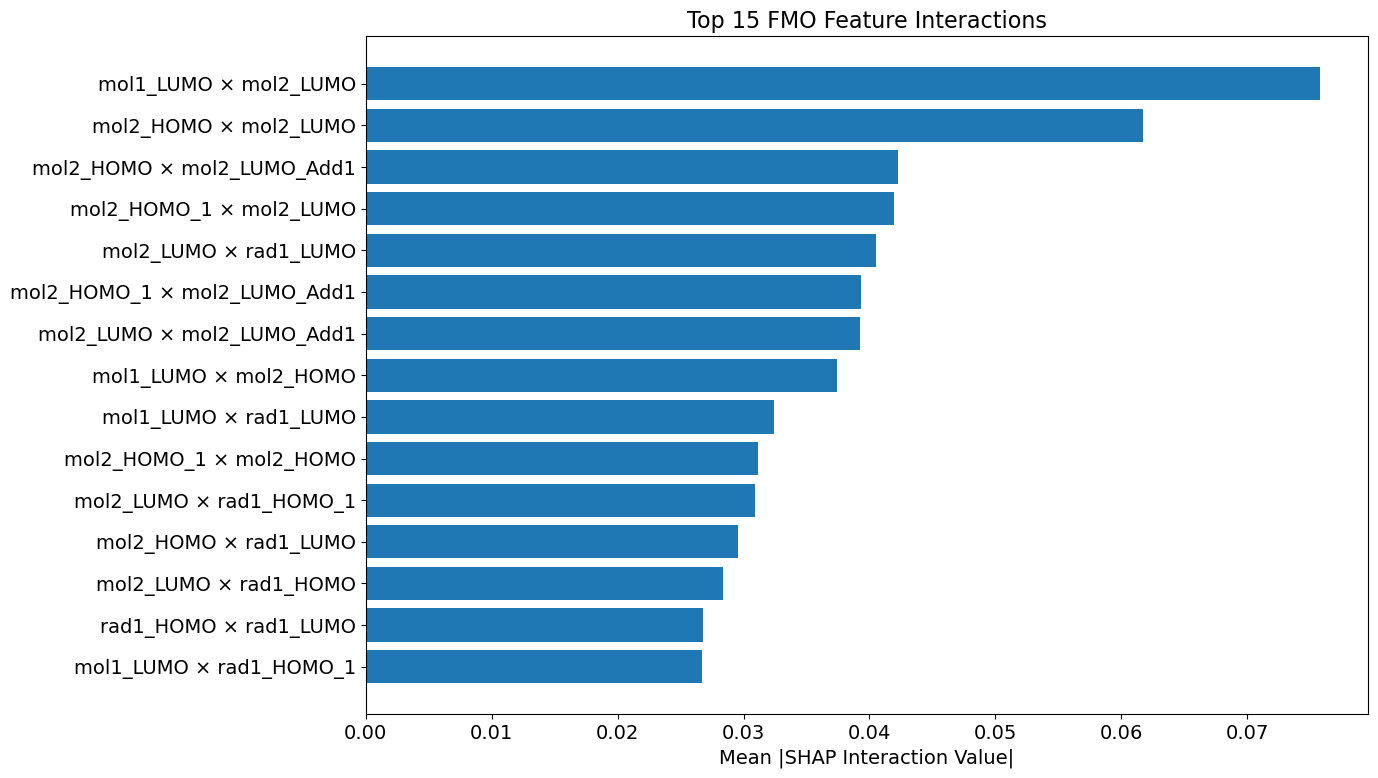

In [ ]:
FMO_interactions = np.zeros((len(FMO_feature_names), len(FMO_feature_names)))

# Fill the interaction matrix with the mean absolute SHAP interaction values
for i in range(len(FMO_feature_names)):
    for j in range(len(FMO_feature_names)):
        FMO_interactions[i, j] = np.abs(shap_FMO_interaction_values[:, i, j]).mean()

# Create a heatmap of the interactions
plt.figure(figsize=(12, 10))
mask = np.zeros_like(FMO_interactions, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # Mask the upper triangle to avoid redundancy

# Optional: Create a bar plot of the most important FMO feature interactions
interaction_importance = []
for i in range(len(FMO_feature_names)):
    for j in range(i+1, len(FMO_feature_names)):
        interaction_importance.append((
            f"{FMO_feature_names[i]} × {FMO_feature_names[j]}",
            np.abs(shap_FMO_interaction_values[:, i, j]).mean()
        ))

# Sort by importance and plot top 15
interaction_importance.sort(key=lambda x: x[1], reverse=True)
top_n = 15
top_interactions = interaction_importance[:top_n]

plt.figure(figsize=(14, 8))
plt.barh([x[0] for x in top_interactions], [x[1] for x in top_interactions])
plt.xlabel('Mean |SHAP Interaction Value|')
plt.title(f'Top {top_n} FMO Feature Interactions', fontsize=16)
plt.gca().invert_yaxis()  # To have the highest value at the top
plt.tight_layout()
plt.show()

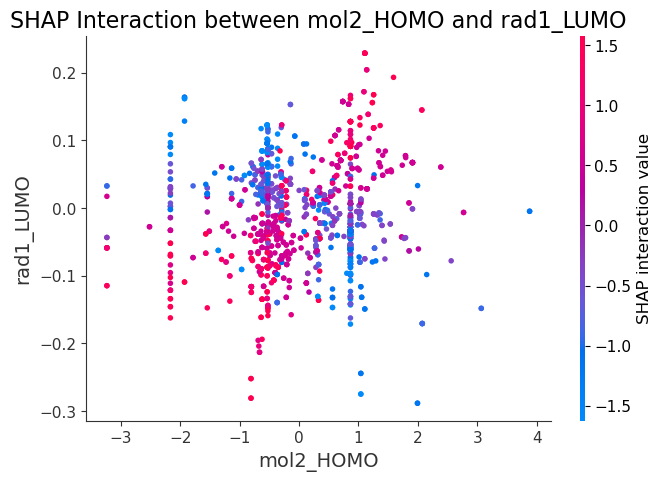

In [ ]:
# Identify the indices for mol1_LUMO and mol2_LUMO features
feature1 = "mol2_HOMO"
feature2 = "rad1_LUMO"

idx1 = FMO_feature_names.index(feature1)
idx2 = FMO_feature_names.index(feature2)

# Create the dependence plot for interaction effects
shap.dependence_plot(
    (idx1, idx2),  # Tuple of feature indices for interaction - swapped order
    shap_FMO_interaction_values,     # The interaction values you calculated
    X_test,                          # Feature matrix
    display_features=X_test,         # Features to display (usually same as features)
    feature_names=FMO_feature_names,      # Feature names
    show=False  # Don't show immediately so we can add title
)

# Fixing a bug: Switch the y-axis and color bar labels
plt.ylabel(feature2, fontsize=14)  
plt.xlabel(feature1, fontsize=14)  
cbar = plt.gcf().axes[-1]  # Get the colorbar
cbar.set_ylabel(f'SHAP interaction value', fontsize=12)  

# Set the title for the plot and show it
plt.title(f'SHAP Interaction between {feature1} and {feature2}', fontsize=16)
plt.show()
